## Description:
The dataset is comprised of tab-separated files with phrases from the IMDB Movie Ratings. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.

test.tsv contains just phrases. You must assign a sentiment label to each phrase. The sentiment labels are:

- 0 : negative 
- 1 : positive

## Objective:
- EDA & cleanup (if required).
- Build classification models to predict the ratings of the movie implemented using the following algorithms:
    - Logistic Regression
    - Naive Bayes
    - Decision Tree
    - Random Forest
    - XGBoost
    
    ...
- Implement the above algorithms with Pyspark.
- Compare the evaluation metrics of vaious classification algorithms.

## Some Initializations

In [1]:
import os
memory = '20g'
pyspark_submit_args = '--executor-memory 4g' + ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initial SparkSession
conf = SparkConf() \
    .set('spark.driver.host', '127.0.0.1') \
    .set("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4") \
    .set("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .setMaster("local").setAppName('MovieReview Sentiment Analysis')
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Set matplotlib style
plt.rcParams['figure.figsize'] = [10, 6]

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

:: loading settings :: url = jar:file:/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/yangchenggang/.ivy2/cache
The jars for the packages stored in: /Users/yangchenggang/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a6ddd3ed-a18d-484e-9b82-51b4f1e06fa2;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.4 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in central
	found com.goo

## 1. Data Exploration

### Loading the data

In [2]:
# Importing the dataset
df = pd.read_csv('./movie.csv', header=0)

# Converting the dataset to spark dataframe
df = spark.createDataFrame(df)

# Showing the first 5 rows of the dataframe
df.show(5)
print(f'Inference: The Dataset consists of {len(df.columns)} features & {df.count()} samples.')

# Printing the schema of the dataframe
df.printSchema()

# Checking the stats of the dataframe
df.describe().show()


+--------------------+-----+
|                text|label|
+--------------------+-----+
|I grew up (b. 196...|    0|
|When I put this m...|    0|
|Why do people who...|    0|
|Even though I hav...|    0|
|Im a die hard Dad...|    1|
+--------------------+-----+
only showing top 5 rows

Inference: The Dataset consists of 2 features & 40000 samples.
root
 |-- text: string (nullable = true)
 |-- label: long (nullable = true)

+-------+--------------------+------------------+
|summary|                text|             label|
+-------+--------------------+------------------+
|  count|               40000|             40000|
|   mean|                null|          0.499525|
| stddev|                null|0.5000060244893201|
|    min|!!!! MILD SPOILER...|                 0|
|    max|ý thýnk uzak ýs t...|                 1|
+-------+--------------------+------------------+



## 2. Data Preprocessing

### Checking for null values

In [3]:
from pyspark.sql.functions import col, count

# Checking for null values
null_check = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_check.show()

print('Inference: The dataset doesn\'t have any null elements' if not null_check.drop('label').toPandas().sum().sum() else '')


+----+-----+
|text|label|
+----+-----+
|   0|    0|
+----+-----+

Inference: The dataset doesn't have any null elements


### Removing the duplicates

In [4]:
# remove duplicates
original_count = df.count()
df = df.dropDuplicates()

# check if duplicates are removed
if df.count() == original_count:
    print('Inference: The dataset doesn\'t have any duplicates')
else:
    print(f'Inference: Number of duplicates dropped/fixed ---> {original_count - df.count()}')


Inference: Number of duplicates dropped/fixed ---> 277


### Spark NLP pipeline

Spark NLP is a Natural Language Processing library built on top of Apache Spark ML. It provides simple, performant & accurate NLP annotations for machine learning pipelines, that scale easily in a distributed environment. We can use Spark NLP to preprocess text data, like removing stop words, normalizing text, tokenizing. In this way, we can get a clean text data for further processing.

We will be using Spark NLP pipeline to preprocess the data. The pipeline consists of the following stages:
- DocumentAssembler: Converts the input string to Spark NLP internal structure (Annotation)
- Tokenizer: Split the document into tokens (words)
- Normalizer: Transforms tokens to Normalized form (lower case, accent removal, etc.)
- Lemmatizer: Break tokens down to their root meaning to identify similar words (car, cars, car's => car)
- Stemmer: Reduce words to their root form (write, writes, writing => writ)
- Finisher: Clean up internal structures and convert to human readable output (Reverts back to text)

In [5]:
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator.token.tokenizer import Tokenizer
from sparknlp.annotator.normalizer import Normalizer
from sparknlp.annotator.lemmatizer import LemmatizerModel
from sparknlp.annotator.stemmer import Stemmer
from sparknlp.annotator.stop_words_cleaner import StopWordsCleaner
from sparknlp.annotator.n_gram_generator import NGramGenerator

# Create all the required annotators
documentAssembler = DocumentAssembler() \
        .setInputCol('text') \
        .setOutputCol('document')

# Tokenize the document 
tokenizer = Tokenizer() \
        .setInputCols(['document']) \
        .setOutputCol('tokenized')

# Normalize the tokens
normalizer = Normalizer() \
        .setInputCols(['tokenized']) \
        .setOutputCol('normalized') \
        .setLowercase(True)

# Stem the normalized tokens
stemmer = Stemmer() \
        .setInputCols(['normalized']) \
        .setOutputCol('stemmed')

# Lemmatize the normalized tokens
lemmatizer = LemmatizerModel.pretrained() \
        .setInputCols(['normalized']) \
        .setOutputCol('lemmatized')

# Remove stopwords from the lemmatized tokens
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
stopwords_cleaner = StopWordsCleaner() \
        .setInputCols(['lemmatized']) \
        .setOutputCol('unigrams') \
        .setStopWords(eng_stopwords)

# Generate unigrams and bigrams
n_grammer = NGramGenerator() \
        .setInputCols(['unigrams']) \
        .setOutputCol('ngrams') \
        .setN(2) \
        .setEnableCumulative(True) \
        .setDelimiter('_')

finisher = Finisher() \
     .setInputCols(['unigrams', 'ngrams', 'stemmed'])


from pyspark.ml import Pipeline
# Create a pipeline
pipeline = Pipeline() \
     .setStages([documentAssembler,                  
                 tokenizer,
                 normalizer,                  
                 lemmatizer,
                 stemmer,                  
                 stopwords_cleaner, 
                 n_grammer,  
                 finisher])

# Transform DataFrame
df = pipeline.fit(df).transform(df)

# Show the first 5 rows of the dataframe after filtering
df.show(5, truncate=False)


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ — ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ \ ]Download done! Loading the resource.
[OK!]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangchenggang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3. Exploratory Data Analysis

In [6]:
plt.rcParams['legend.fontsize'] = 'large'

### Distribution of the labels(review ratings)

The distribution of the labels can show us if the dataset is balanced or not. If the dataset is not balanced, we can use techniques like oversampling or undersampling to balance the dataset.

              Target Variable Distribution             


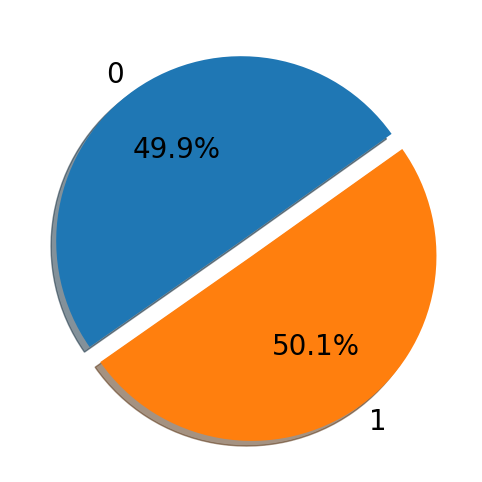

In [7]:
target = 'label'

# analyze the distribution of the target variable

print('Target Variable Distribution'.center(55))
target_distribution = df.groupBy(target).count().collect()

# extract the labels and the counts from the target distribution
labels = [row[target] for row in target_distribution]
counts = [row['count'] for row in target_distribution]

# plot the distribution of the target variable
plt.rcParams['font.size'] = 20
plt.pie(counts, labels=labels, counterclock=False, shadow=True, 
        explode=[0, 0.1], autopct='%1.1f%%', radius=1, startangle=215)
plt.show()
plt.rcParams['font.size'] = 10


`Inference`: The Target Variable seems to be perfectly balanced!

### Visualizing the average text sequence length

We use boxplot to visualize the average text sequence length. Boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It is often used in explanatory data analysis.

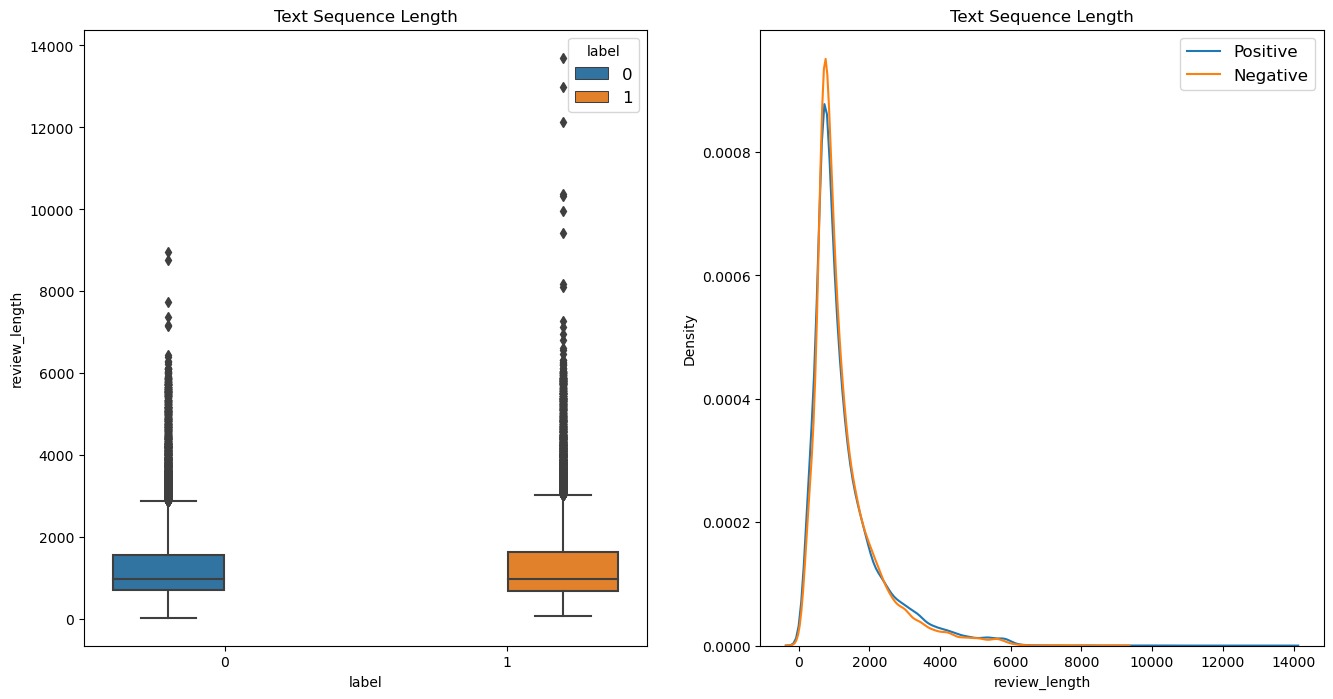

In [8]:
from pyspark.sql.functions import length

# count the length of each review
df = df.withColumn("review_length", length("text"))

# convert the DataFrame to Pandas and plot the histogram
df_pd = df.select(['label', 'review_length']).toPandas()

plt.figure(figsize=[16, 8])

# plot the boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='review_length', data=df_pd, hue='label')
plt.title('Text Sequence Length')

# Splitting the data into positive and negative reviews
df_pd_pos = df_pd[df_pd['label'] == 1]
df_pd_neg = df_pd[df_pd['label'] == 0]

# Plotting the distribution of the length of positive and negative reviews
plt.subplot(1, 2, 2)
sns.distplot(df_pd_pos['review_length'], hist=False, label='Positive')
sns.distplot(df_pd_neg['review_length'], hist=False, label='Negative')
# Add labels and title
plt.title('Text Sequence Length')
plt.legend()
plt.show()

`Inference`: Some Positive reviews are slightly longer on an average, compared to those with negative reviews.

We can also visualize the distribution of the text sequence length on both the classes using a histogram.

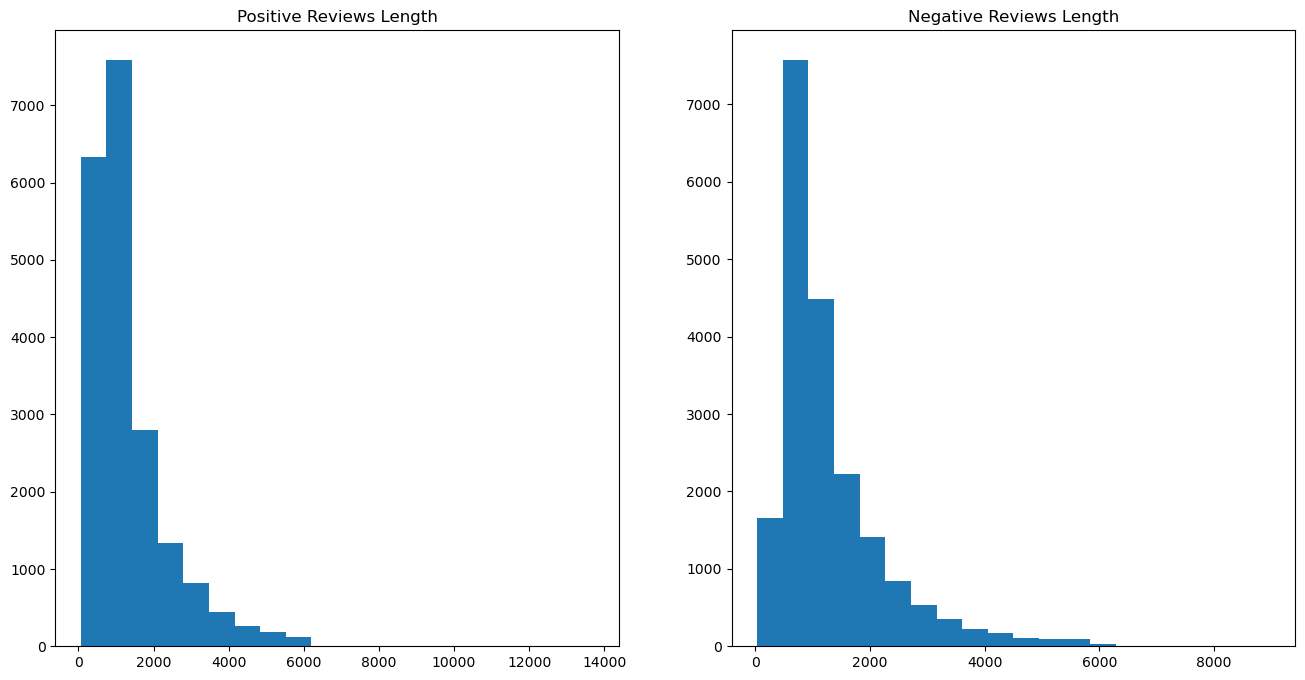

In [9]:
plt.figure(figsize=[16, 8])

# left plot
plt.subplot(1, 2, 1)
# plot the histogram of the length of positive reviews
plt.hist(df_pd_pos['review_length'], bins=20, label='Positive')
plt.title('Positive Reviews Length')

# right plot
plt.subplot(1, 2, 2)
# plot the histogram of the length of negative reviews
plt.hist(df_pd_neg['review_length'], bins=20, label='Negative')
plt.title('Negative Reviews Length')

plt.show()

### Visualizing the stem using WordCloud

WordCloud is a technique to show which words are the most frequent among the given text. The more frequent the word is, the larger is the size of the word in the WordCloud image. The WordCloud of the positive and negative reviews are shown below.

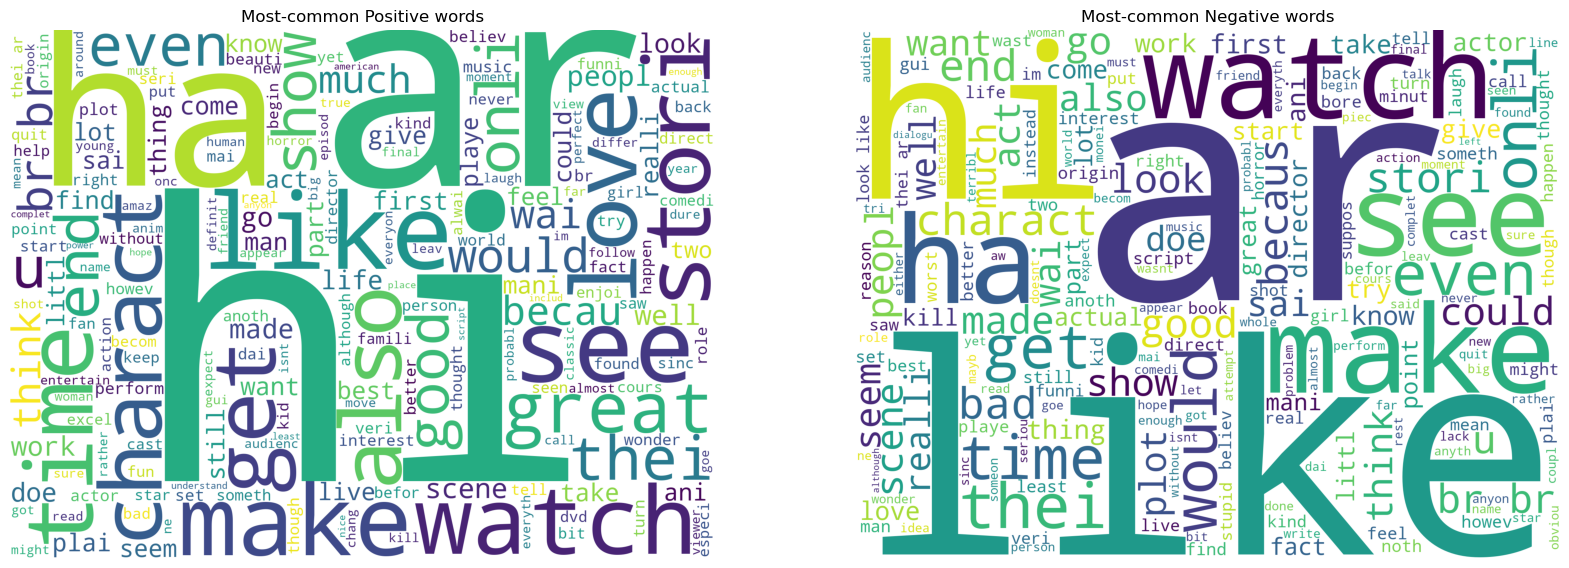

In [10]:
from wordcloud import WordCloud

# extract the positive and negative reviews
positivedata = df.filter(df['label'] == 1).select('finished_stemmed').rdd.flatMap(lambda x: x).collect()
negdata = df.filter(df['label'] == 0).select('finished_stemmed').rdd.flatMap(lambda x: x).collect()

# define a function to plot wordcloud
def wordcloud_draw(data, color, title):
    data = [item for sublist in data for item in sublist]
    # join all the sentences
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if word not in ['movi', 'film', 'thi', 'wa']])
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color=color, width=2000, height=1500).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')

# plot wordcloud
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1)
wordcloud_draw(positivedata, 'white', 'Most-common Positive words')

plt.subplot(1, 2, 2)
wordcloud_draw(negdata, 'white', 'Most-common Negative words')
plt.show()


`Inference`: There are some words that are with large frequency in positive reviews but with small frequency in negative reviews, and vice versa. For example,
- The word "great" is a word with large frequency in positive reviews but with small frequency in negative reviews, so as stem "great".
- The word "bad" is a word with large frequency in negative reviews but with small frequency in positive reviews, so as stem "bad".

For these kind of words, we can simply realize that they are meaningful to distinguish positive and negative reviews, which is also apparently understandable.

### Visualizing the top frequent words using barplot

Barplot is a technique to show which words are the most frequent among the given text. The more frequent the word is, the higher is the bar in the barplot. And barplot is a good way to show the top frequent words more clearly than WordCloud.

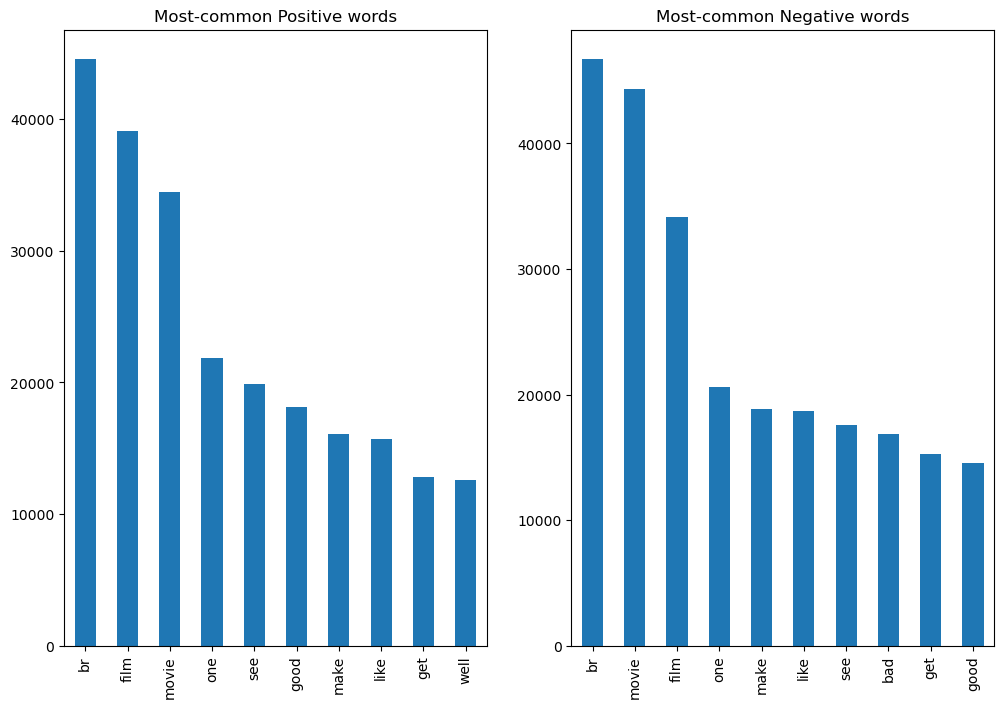

In [11]:
# extract the positive and negative reviews
positivedata = df.filter(df['label'] == 1).select('finished_unigrams').rdd.flatMap(lambda x: x).collect()
negdata = df.filter(df['label'] == 0).select('finished_unigrams').rdd.flatMap(lambda x: x).collect()

def barplot_draw(data, title):
    # flatten the list
    data = [item for sublist in data for item in sublist]
    # create a pandas series
    data = pd.Series(data)
    # count the number of each word
    data = data.value_counts()
    # plot bar chart
    data[:10].plot(kind='bar')
    plt.title(title)

# plot bar chart
plt.figure(figsize=[12, 8])
plt.subplot(1, 2, 1)
barplot_draw(positivedata, 'Most-common Positive words')

plt.subplot(1, 2, 2)
barplot_draw(negdata, 'Most-common Negative words')
plt.show()

`Inference`: The two classes share the common words in top 10 list, such as "br", "film", "movie", "one", "like", "good", "make", "get". In positive reviews, it have comparatively more words related to positive emotion, such as "well". In negative reviews, it have comparatively more words related to negative emotion, such as "bad".

### Basic Sentiment Analysis

Vader and TextBlob are two libraries that can be used to perform sentiment analysis. We will be using TextBlob to perform simple sentiment analysis on the reviews.

Vader polarity score is a float within the range [-1.0, 1.0]. The positive score indicates the positive sentiment and the negative score indicates the negative sentiment. The higher the positive score is, the more positive the sentiment is. The lower the negative score is, the more negative the sentiment is. And Vader is designed to handle social media texts, which can process slangs and emojis.

TextBlob polarity score is a float within the range [-1.0, 1.0]. The score value indicates the sentiment polarity as Vader. And TextBlob is designed to handle normal texts, more general, but may not be as sensitive to network specific expressions as Vader.


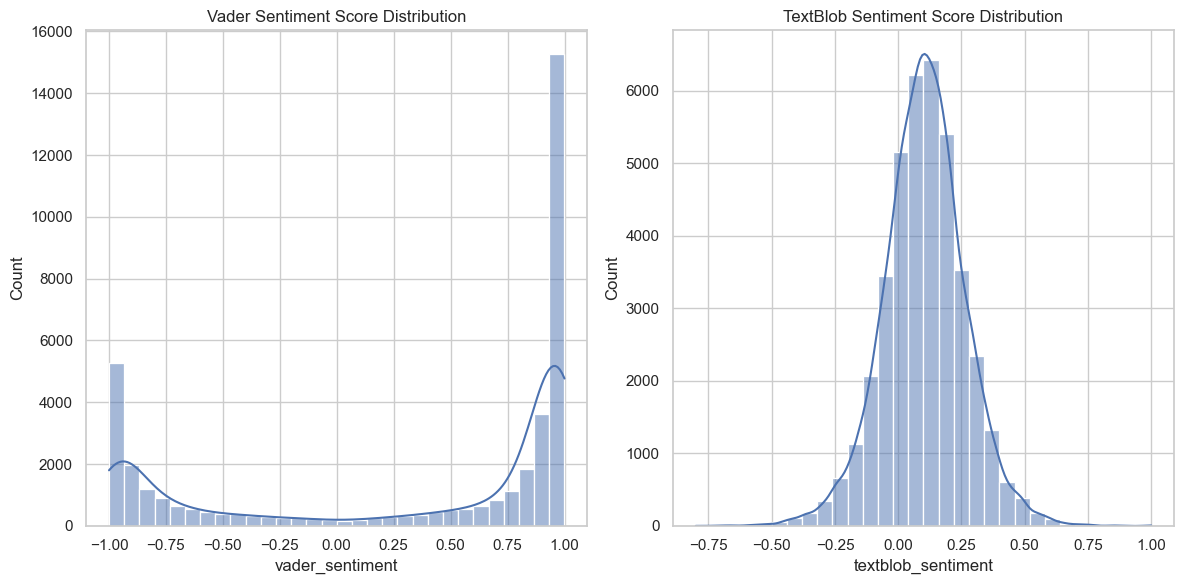

In [12]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd

# define Vader sentiment analysis function
def vader_sentiment_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)['compound']

# define TextBlob sentiment analysis function
def textblob_sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

# get Pandas DataFrame from Spark DataFrame
df_pd = df.select(['text']).toPandas()

# apply Vader sentiment analysis function to the Pandas DataFrame
df_pd['vader_sentiment'] = df_pd['text'].apply(vader_sentiment_analysis)

# apply TextBlob sentiment analysis function to the Pandas DataFrame
df_pd['textblob_sentiment'] = df_pd['text'].apply(textblob_sentiment_analysis)

# plot the histogram of the Vader and TextBlob sentiment scores
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df_pd['vader_sentiment'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Vader Sentiment Score Distribution')
sns.histplot(df_pd['textblob_sentiment'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('TextBlob Sentiment Score Distribution')
plt.tight_layout()
plt.show()


`Inference`: Two libraries have different distributions of the positive and negative scores.

- **Vader**: The distribution of the positive and negative scores are distinct. Some reviews have higher positive scores , while other reviews have higher negative scores. And this is consistent with the distribution of the labels somehow. However, the distribution of the positive scores and negative scores are not symmetric. It seems that more reviews have higher positive scores than negative scores.
- **TextBlob**: The distribution of the positive and negative scores are not distinct. The most reviews have a similar polarity score, which is around 0. And this is not consistent with the distribution of the labels. This may be because TextBlob is not designed to handle social media texts, which can process slangs and emojis.

## 4. Model Building

### Vectorizing the text data

Before we start building the models, we need to convert the text data into numerical data. We will be using TF-IDF vectorizer, Count vectorizer and Word2Vec to convert the text data into numerical data. 

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling.

Count vectorizer is a simple method to convert a collection of text documents to a matrix of token counts. It is important to note that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal. It is a way of BoW representation, where the BoW vector is the histogram of the frequencies of each word in the text.

Word2Vec is a method to construct such an words-embedding. It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW). The idea is to have a higher dimension dense vector for each word instead of a huge sparse one-hot word vector. The main advantage of this method is that words with similar meaning are close to each other in the vector space.

In [8]:
from pyspark.ml.feature import HashingTF, IDF, CountVectorizer, Word2Vec

# create a TF vectorizer
hashing_TF = HashingTF(inputCol='finished_ngrams', outputCol='tf_features')
tf_df = hashing_TF.transform(df)

# create an IDF estimator
idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_df)
tfidf_df = idf_model.transform(tf_df)

# create a CountVectorizer
cv = CountVectorizer(inputCol='finished_unigrams', outputCol='cv_features', vocabSize=3, minDF=2.0)
cv_model = cv.fit(tfidf_df)
cv_df = cv_model.transform(tfidf_df)

# create a Word2Vec vectorizer
word2vec = Word2Vec(inputCol='finished_unigrams', outputCol='w2v_features', vectorSize=3, minCount=0, seed=42)
w2v_model = word2vec.fit(cv_df)
w2v_df = w2v_model.transform(cv_df)

feature_df = w2v_df.select(['label', 'tf_idf_features', 'cv_features', 'w2v_features'])


### Initializing some variables

#### Splitting the data into train and test sets

In [9]:
# Ensure that the labels are of float type
feature_df = feature_df.withColumn("label", feature_df["label"].cast("float"))

# Split the data
(train_data, test_data) = feature_df.randomSplit([0.8, 0.2], seed=42)

# Normalize the features
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol="tf_idf_features", outputCol="tf_idf_scaled", withStd=True, withMean=False)
# scalerModel = scaler.fit(train_data)
# train_data = scalerModel.transform(train_data)
# test_data = scalerModel.transform(test_data)

# scaler = StandardScaler(inputCol="cv_features", outputCol="cv_scaled", withStd=True, withMean=False)
# scalerModel = scaler.fit(train_data)
# train_data = scalerModel.transform(train_data)
# test_data = scalerModel.transform(test_data)

# scaler = StandardScaler(inputCol="w2v_features", outputCol="w2v_scaled", withStd=True, withMean=False)
# scalerModel = scaler.fit(train_data)
# train_data = scalerModel.transform(train_data)
# test_data = scalerModel.transform(test_data)

# Show the number of samples in each set
print('Original set  ---> ', feature_df.count(), len(feature_df.columns))
print('Training set  ---> ', train_data.count(), len(train_data.columns))
print('Testing set   ---> ', test_data.count(), len(test_data.columns))

Original set  --->  39723 4


Training set  --->  31786 4


Testing set   --->  7937 4


#### Initializing the metrics for model evaluation

In [10]:
# Create a dictionary to store the test results of each model
Evaluation_Results = {
    'LR': [0] * 5,
    'NB': [0] * 5,
    'RF': [0] * 5,
    'GB': [0] * 5
}

# Convert the dictionary to a pandas DataFrame
Evaluation_Results_df = pd.DataFrame(Evaluation_Results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC score']).T
Evaluation_Results_Valid_df = pd.DataFrame(Evaluation_Results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC score']).T
Evaluation_Results_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
LR,0,0,0,0,0
NB,0,0,0,0,0
RF,0,0,0,0,0
GB,0,0,0,0,0


#### Defining the function for model evaluation

Classification evaluation metrics are used to access the performance of a classifier. The metrics are used to access the performance of the model on the test set. The metrics that we will be using are:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC

In [14]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import roc_curve, auc

# Classification Summary Function
def classification_summary(predictions, model_name, validation=False):
    
    # Compute the confusion matrix
    rdd = predictions.select(['prediction', 'label']).rdd.map(tuple)    
    metrics = MulticlassMetrics(rdd)
    confusion_matrix = metrics.confusionMatrix().toArray()
    # Plot the confusion matrix
    if not validation:
        print('\nConfusion Matrix:')
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    # Compute various metrics
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy = confusion_matrix.diagonal().sum() / confusion_matrix.sum()
    precision = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[0][1])
    recall = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[1][0])
    f1 = 2 * precision * recall / (precision + recall)
    
    # Compute AUC-ROC
    # Convert predictions to Pandas DataFrame
    predictions_pd = predictions.select("probability", "label").toPandas()

    # Extract the probability of the positive class
    prob_positive_class = predictions_pd.apply(lambda row: row['probability'][1], axis=1)

    # Compute FPR, TPR, and AUC-ROC
    fpr, tpr, _ = roc_curve(predictions_pd['label'], prob_positive_class)
    auc_roc = auc(fpr, tpr)

    # Update the results dataframe
    if validation:
        Evaluation_Results_Valid_df.loc[model_name] = [accuracy*100, precision*100, recall*100, f1*100, auc_roc*100]
    else:
        Evaluation_Results_df.loc[model_name] = [accuracy*100, precision*100, recall*100, f1*100, auc_roc*100]
    
    # Print the results
    print('Accuracy = {:.2f}%'.format(accuracy * 100))
    print('Precision = {:.2f}%'.format(precision * 100))
    print('Recall = {:.2f}%'.format(recall * 100))
    print('F1 Score = {:.2f}%'.format(f1 * 100))
    print('AUC-ROC = {:.2f}%'.format(auc_roc * 100))

    if not validation:
        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

### Logistic Regression

Logistic Regression is a classification algorithm used to assign observations to a discrete set of classes. Some of the applications of Logistic Regression are:
- Image Segmentation and Categorization
- Geographic Image Processing
- Handwriting recognition
- Healthcare: Analyzing a group of over million people for myocardial infarction within a period of 10 years is an application area of logistic regression.

Logistic Regression is a special case of Linear Regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. It basically predicts the probability of occurrence of an event by fitting data to a logit function.



In [17]:
# Logistic Regression Classifier
# Test on different Vectorizers
vector_types = ['tf_idf_features', 'cv_features', 'w2v_features']
bestAccuracy = 0
bestVectorizer = None
for vector_type in vector_types:
    model = LogisticRegression(featuresCol=vector_type, labelCol='label')
    model = model.fit(train_data)
    predictions = model.transform(test_data)
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())

    print("===========================================================")
    print("Type of Vectorizer: ", vector_type)
    print("Accuracy: ", accuracy)

    # save the best model
    if accuracy > bestAccuracy:
        bestAccuracy = accuracy
        bestModel = model
        bestVectorizer = vector_type

Type of Vectorizer:  tf_idf_features
Accuracy:  0.8437696862794507


Type of Vectorizer:  cv_features
Accuracy:  0.5498299105455462


Type of Vectorizer:  w2v_features
Accuracy:  0.6365125362227542


In [22]:
# # Use the best Vector to Cross Validate the model
# Create a Logistic Regression Classifier
bestVectorizer = 'tf_idf_features'
model = LogisticRegression(featuresCol=bestVectorizer, labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(model.regParam, [0.02]) \
    .addGrid(model.elasticNetParam, [0.0]) \
    .addGrid(model.maxIter, [100]) \
    .build()
evaluator = MulticlassClassificationEvaluator(labelCol="label")

crossval = CrossValidator(estimator=model,
                      estimatorParamMaps=paramGrid,
                      evaluator=evaluator,
                      numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel
print("===========================================================")
print("Best Type of Vectorizer: ", bestVectorizer)
print("Best Param (regParam): ", bestModel._java_obj.getRegParam())
print("Best Param (elasticNetParam): ", bestModel._java_obj.getElasticNetParam())
print("Best Param (maxIter): ", bestModel._java_obj.getMaxIter())   

Best Type of Vectorizer:  tf_idf_features
Best Param (regParam):  0.02
Best Param (elasticNetParam):  0.0
Best Param (maxIter):  100


Best Validation F1-Score:  0.8418193154723203
<<<----------------------------------- Testing LR ----------------------------------->>>



/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Confusion Matrix:


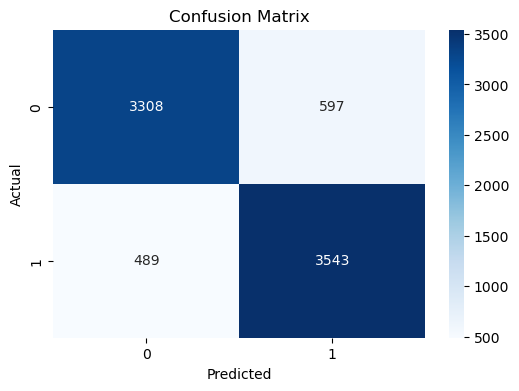

Accuracy = 86.32%
Precision = 85.58%
Recall = 87.87%
F1 Score = 86.71%
AUC-ROC = 93.21%


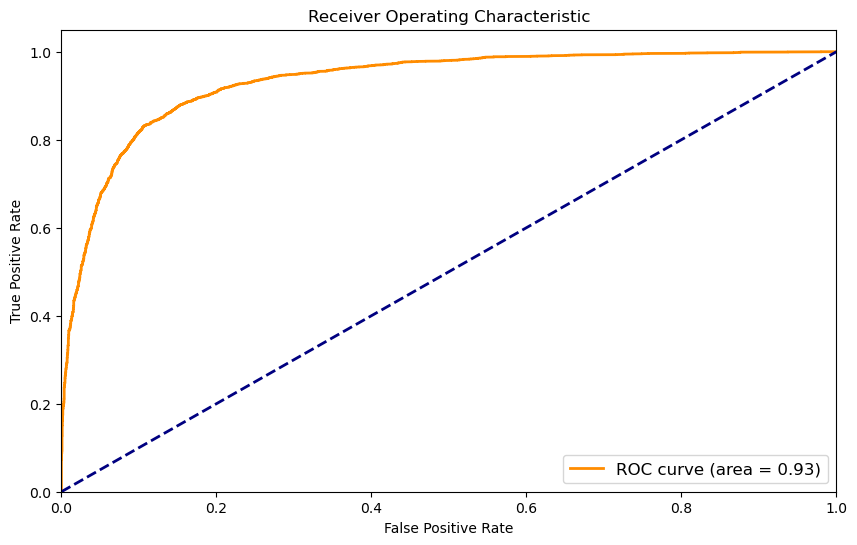

In [23]:
# Validation
avg_metrics = cvModel.avgMetrics
params = cvModel.getEstimatorParamMaps()
all_params = list(zip(params, avg_metrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]
print("Best Validation F1-Score: ", best_param[1])

# Make predictions on test data
predictions = bestModel.transform(test_data)

# Evaluate the model
print('{}{}\033[1m Testing {} \033[0m{}{}\n'.format('<'*3,'-'*35, 'LR', '-'*35,'>'*3))
classification_summary(predictions, 'LR')

### Naive Bayes

Naive Bayes is a classification algorithm based on Bayes’ Theorem. It is termed as ‘Naive’ because it assumes independence between every pair of feature in the data. Let’s understand the working of Naive Bayes through an example. Suppose we have a dataset of weather conditions and corresponding target variable ‘Play’ indicating whether or not the match will be played. Now, we need to classify whether players will play or not based on weather condition. Let’s follow the below steps to perform it.

In [20]:
# Naive Bayes Classifier
# Test on different Vectorizers
vector_types = ['tf_idf_features', 'cv_features']
bestAccuracy = 0
bestVectorizer = None
for vector_type in vector_types:
    model = NaiveBayes(featuresCol=vector_type, labelCol='label')
    model = model.fit(train_data)
    predictions = model.transform(test_data)
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())

    print("===========================================================")
    print("Type of Vectorizer: ", vector_type)
    print("Accuracy: ", accuracy)

    # save the best model
    if accuracy > bestAccuracy:
        bestAccuracy = accuracy
        bestModel = model
        bestVectorizer = vector_type

Type of Vectorizer:  tf_idf_features
Accuracy:  0.8333123346352526


Type of Vectorizer:  cv_features
Accuracy:  0.5396245432783168


In [24]:
# # Use the best Vector to Cross Validate the model
# Create a Naive Bayes Classifier
bestVectorizer = 'tf_idf_features'
model = NaiveBayes(featuresCol=bestVectorizer, labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(model.smoothing, [1.2]) \
    .addGrid(model.thresholds, [[0.2, 0.8]]) \
    .build()
evaluator = MulticlassClassificationEvaluator(labelCol="label")

crossval = CrossValidator(estimator=model,
                      estimatorParamMaps=paramGrid,
                      evaluator=evaluator,
                      numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel
print("===========================================================")
print("Best Type of Vectorizer: ", bestVectorizer)
print("Best Param (smoothing): ", bestModel._java_obj.getSmoothing())
print("Best Param (thresholds): ", bestModel._java_obj.getThresholds())

Best Type of Vectorizer:  tf_idf_features
Best Param (smoothing):  1.2
Best Param (thresholds):  [D@1b5dc4eb


Best Validation F1-Score:  0.8120476770975505
<<<----------------------------------- Testing LR ----------------------------------->>>



/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Confusion Matrix:


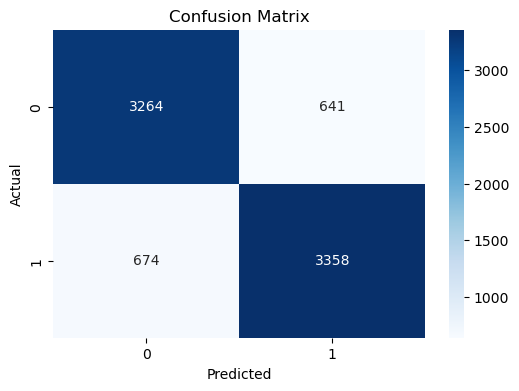

Exception ignored in: <function JavaModelWrapper.__del__ at 0x1797b09d0>        
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/mllib/common.py", line 152, in __del__
    assert self._sc._gateway is not None
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'


Accuracy = 83.43%
Precision = 83.97%
Recall = 83.28%
F1 Score = 83.63%
AUC-ROC = 89.66%


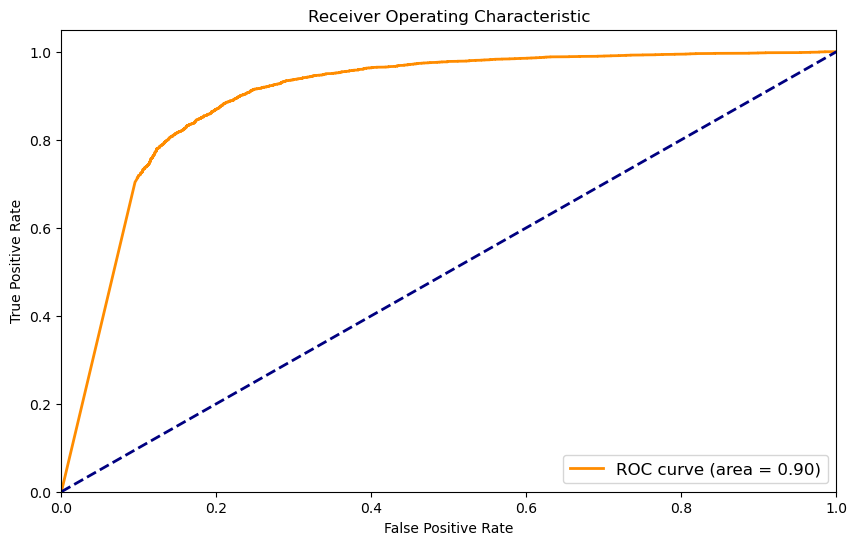

In [25]:
# Validation
avg_metrics = cvModel.avgMetrics
params = cvModel.getEstimatorParamMaps()
all_params = list(zip(params, avg_metrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]
print("Best Validation F1-Score: ", best_param[1])

# Make predictions on test data
predictions = bestModel.transform(test_data)

# Evaluate the model
print('{}{}\033[1m Testing {} \033[0m{}{}\n'.format('<'*3,'-'*35, 'LR', '-'*35,'>'*3))
classification_summary(predictions, 'NB')

### Random Forest

Random Forest is a classic machine learning ensemble method that is a popular choice in data science. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging. Bagging is a technique where a subset of the dataset is selected randomly, and a model is built on top of this subset. This model is then used to make predictions on the entire dataset. The predictions from each model are then combined using a simple majority vote (for classification) or average (for regression) to get the final prediction.

In [23]:
# Random Forest Classifier
# Test on different Vectorizers
vector_types = ['tf_idf_features', 'cv_features', 'w2v_features']
bestAccuracy = 0
bestVectorizer = None
for vector_type in vector_types:
    model = RandomForestClassifier(featuresCol=vector_type, labelCol='label')
    model = model.fit(train_data)
    predictions = model.transform(test_data)
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())

    print("===========================================================")
    print("Type of Vectorizer: ", vector_type)
    print("Accuracy: ", accuracy)

    # save the best model
    if accuracy > bestAccuracy:
        bestAccuracy = accuracy
        bestModel = model
        bestVectorizer = vector_type

Type of Vectorizer:  tf_idf_features
Accuracy:  0.7080760992818446


Type of Vectorizer:  cv_features
Accuracy:  0.5528537230691697


Type of Vectorizer:  w2v_features
Accuracy:  0.632858762756709


In [26]:
# # Use the best Vector to Cross Validate the model
# Create a Random Forest Classifier
bestVectorizer = 'tf_idf_features'
model = RandomForestClassifier(featuresCol=bestVectorizer, labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [4]) \
    .addGrid(model.numTrees, [15]) \
    .addGrid(model.maxBins, [16]) \
    .build()
evaluator = MulticlassClassificationEvaluator(labelCol="label")

crossval = CrossValidator(estimator=model,
                      estimatorParamMaps=paramGrid,
                      evaluator=evaluator,
                      numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel
print("===========================================================")
print("Best Type of Vectorizer: ", bestVectorizer)
print("Best Param (maxDepth): ", bestModel._java_obj.getMaxDepth())
print("Best Param (numTrees): ", bestModel._java_obj.getNumTrees())
print("Best Param (maxBins): ", bestModel._java_obj.getMaxBins())

Best Type of Vectorizer:  tf_idf_features
Best Param (maxDepth):  4
Best Param (numTrees):  15
Best Param (maxBins):  16


Best Validation F1-Score:  0.6688980598591278
<<<----------------------------------- Testing LR ----------------------------------->>>



/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Confusion Matrix:


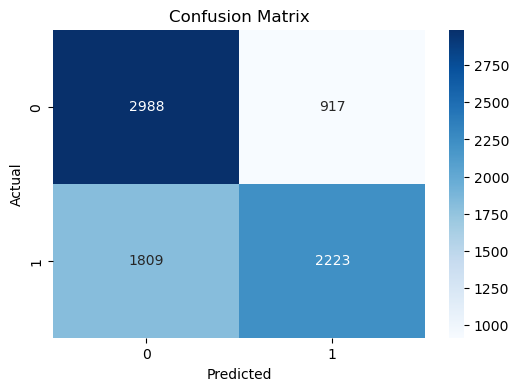

Accuracy = 65.65%
Precision = 70.80%
Recall = 55.13%
F1 Score = 61.99%
AUC-ROC = 73.09%


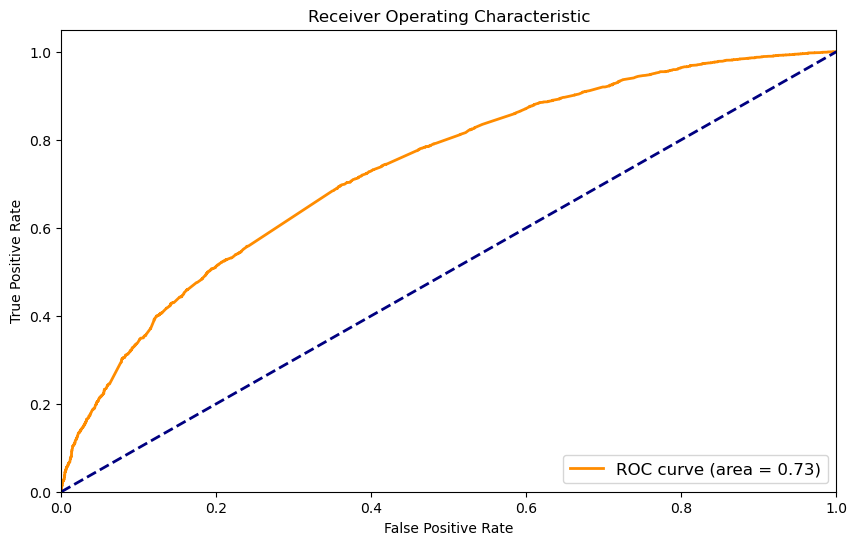

In [27]:
# Validation
avg_metrics = cvModel.avgMetrics
params = cvModel.getEstimatorParamMaps()
all_params = list(zip(params, avg_metrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]
print("Best Validation F1-Score: ", best_param[1])

# Make predictions on test data
predictions = bestModel.transform(test_data)

# Evaluate the model
print('{}{}\033[1m Testing {} \033[0m{}{}\n'.format('<'*3,'-'*35, 'LR', '-'*35,'>'*3))
classification_summary(predictions, 'RF')

### Gradient Boosting

Gradient Boosting is a variant version of boosting. It works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [ ]:
# Random Forest Classifier
# Test on different Vectorizers
vector_types = ['tf_idf_features', 'cv_features', 'w2v_features']
bestAccuracy = 0
bestVectorizer = None
for vector_type in vector_types:
    model = GBTClassifier(featuresCol=vector_type, labelCol='label')
    model = model.fit(train_data)
    predictions = model.transform(test_data)
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())

    print("===========================================================")
    print("Type of Vectorizer: ", vector_type)
    print("Accuracy: ", accuracy)

    # save the best model
    if accuracy > bestAccuracy:
        bestAccuracy = accuracy
        bestModel = model
        bestVectorizer = vector_type

In [29]:
# # Use the best Vector to Cross Validate the model
# Create a Gradient Boosting Classifier
bestVectorizer = 'w2v_features'
model = GBTClassifier(featuresCol=bestVectorizer, labelCol='label')

paramGrid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [4]) \
    .addGrid(model.maxBins, [16]) \
    .addGrid(model.subsamplingRate, [0.8]) \
    .build()
evaluator = MulticlassClassificationEvaluator(labelCol="label")

crossval = CrossValidator(estimator=model,
                      estimatorParamMaps=paramGrid,
                      evaluator=evaluator,
                      numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel
print("===========================================================")
print("Best Type of Vectorizer: ", bestVectorizer)
print("Best Param (maxDepth): ", bestModel._java_obj.getMaxDepth())
print("Best Param (maxBins): ", bestModel._java_obj.getMaxBins())
print("Best Param (subsamplingRate): ", bestModel._java_obj.getSubsamplingRate())

Best Type of Vectorizer:  w2v_features
Best Param (maxDepth):  4
Best Param (maxBins):  16
Best Param (subsamplingRate):  0.8


Best Validation F1-Score:  0.6323388447619964
<<<----------------------------------- Testing LR ----------------------------------->>>



/Applications/anaconda3/envs/CS5344/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Confusion Matrix:


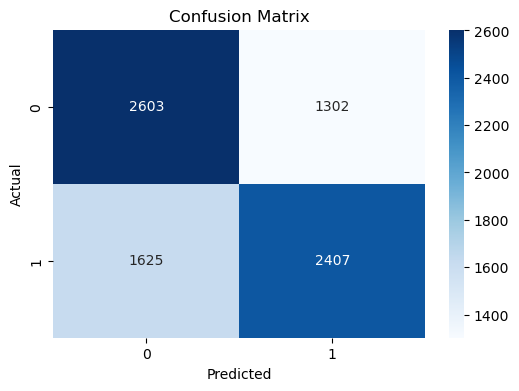

Accuracy = 63.12%
Precision = 64.90%
Recall = 59.70%
F1 Score = 62.19%
AUC-ROC = 68.89%


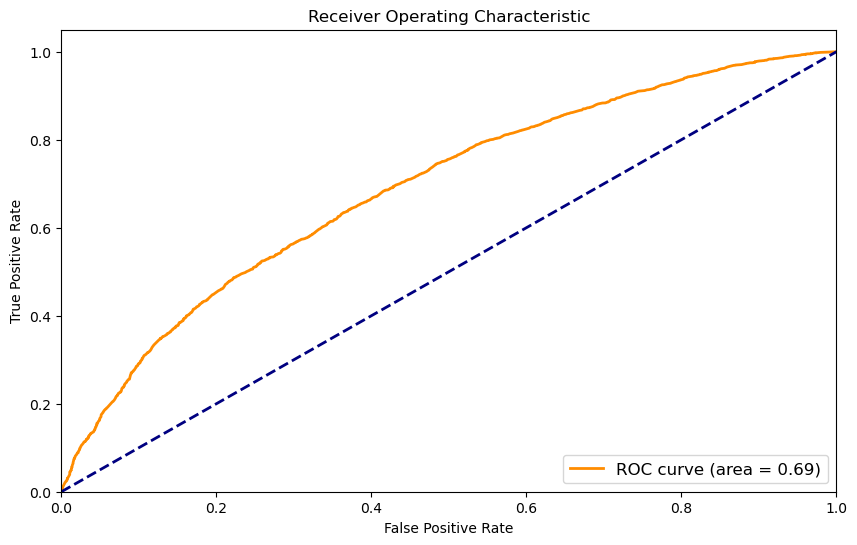

In [30]:
# Validation
avg_metrics = cvModel.avgMetrics
params = cvModel.getEstimatorParamMaps()
all_params = list(zip(params, avg_metrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]
print("Best Validation F1-Score: ", best_param[1])

# Make predictions on test data
predictions = bestModel.transform(test_data)

# Evaluate the model
print('{}{}\033[1m Testing {} \033[0m{}{}\n'.format('<'*3,'-'*35, 'LR', '-'*35,'>'*3))
classification_summary(predictions, 'GB')

### Show the Recall, Precision, F1-Score, ROC-AUC for all the models


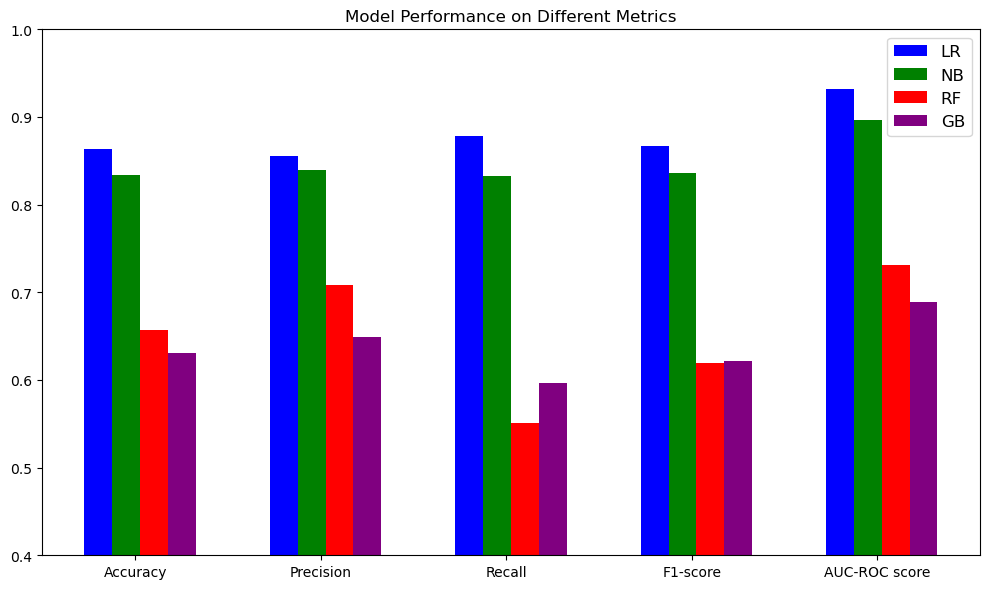

In [107]:
# Adjusting the visualization to use different colors for different models

# Define a color palette for the models
model_colors = {'LR': 'blue', 'NB': 'green', 'RF': 'red', 'GB': 'purple'}

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting with different colors for each model
for i, model in enumerate(Evaluation_Results_df.index):
    # Set the positions of the bars on the x-axis for each model
    indices = np.arange(len(Evaluation_Results_df.columns)) + i * 0.15
    ax.bar(indices, Evaluation_Results_df.loc[model] / 100, 0.15, label=model, color=model_colors[model])

# Add some text for labels and title
ax.set_title('Model Performance on Different Metrics')
ax.set_xticks(np.arange(len(Evaluation_Results_df.columns)) + 0.2)
ax.set_xticklabels(Evaluation_Results_df.columns)
ax.set_ylim(0.4, 1.0)  # Adjusting y-axis limits
ax.legend()

plt.tight_layout()
plt.show()

### Show the Validation F1-Score and Test F1-Score for all the models

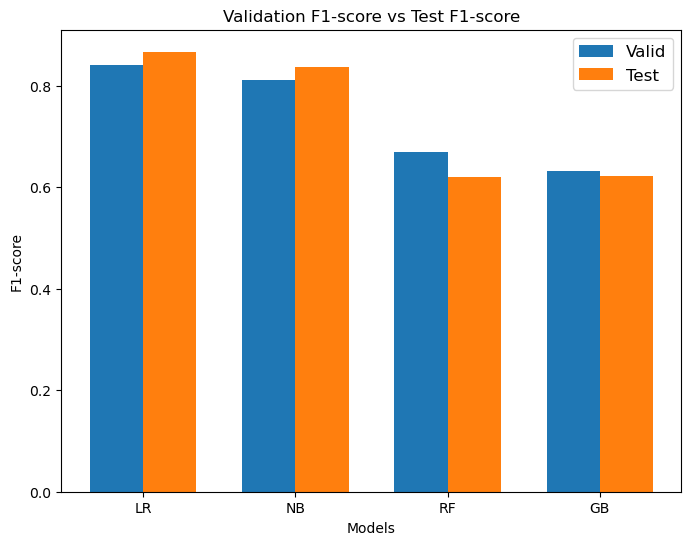

In [82]:
# Validation F1-Score for all models
# Creating a visualization with both test and valid data for F1-score only, for each model

# Sample data with only F1-score for demonstration
# Test data
Evaluation_Results_Test_df = pd.DataFrame({
    'F1-score': Evaluation_Results_df['F1-score'] / 100
}, index=['LR', 'NB', 'RF', 'GB']).T

# Valid data
Evaluation_Results_Valid_df = pd.DataFrame({
    'F1-score': [0.841819, 0.812048, 0.668898, 0.632339]
}, index=['LR', 'NB', 'RF', 'GB']).T

# Initialize the matplotlib figure with the new style
fig, ax = plt.subplots(figsize=(8, 6))

# Number of models
n_models = len(Evaluation_Results_Test_df.columns)
width = 0.35  # the width of the bars

# Create bars for F1-score of each model for both test and valid data
ax.bar(np.arange(n_models) - width/2, Evaluation_Results_Valid_df.loc['F1-score'], width, label='Valid')
ax.bar(np.arange(n_models) + width/2, Evaluation_Results_Test_df.loc['F1-score'], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('F1-score')
ax.set_title('Validation F1-score vs Test F1-score')
ax.set_xticks(np.arange(n_models))
ax.set_xticklabels(Evaluation_Results_Test_df.columns)
ax.legend()

plt.show()

